In [1]:
# imports and preliminaries

try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq

import cirq_google
from cirq.circuits import InsertStrategy

import numpy as np
import matplotlib.pyplot as plt

# Circuit 1

In [2]:
# create circuit with 5 qubits
circuit = cirq.Circuit()
num_qubits = 5
qubits = cirq.LineQubit.range(num_qubits)


# add hadamard gates
for i in range(num_qubits):
    circuit.append(cirq.H(qubits[i]))

# add cnot gates
for j in range(num_qubits-1):
    circuit.append(cirq.CNOT(qubits[j], qubits[j+1]))

# swap gate between q0 and q4
circuit.append(cirq.SWAP(qubits[0], qubits[4]))


# rotation about pauli X gate by pi/2
# used the insert strategy = new, to demonstrate its use and keep the circuit clean
circuit.append(cirq.rx(0.5 * np.pi).on(qubits[2]), strategy=InsertStrategy.NEW)

print(circuit)

0: ───H───@───────────────×──────────────
          │               │
1: ───H───X───@───────────┼──────────────
              │           │
2: ───H───────X───@───────┼───Rx(0.5π)───
                  │       │
3: ───H───────────X───@───┼──────────────
                      │   │
4: ───H───────────────X───×──────────────


In [3]:
# Initialize Simulator
s = cirq.Simulator()

print('Simulate the circuit:')
results = s.simulate(circuit)
print(results)

# For sampling, we need to add a measurement at the end
circuit.append(cirq.measure(qubits[0], qubits[1], qubits[2], qubits[3], qubits[4], key='result'))

# Sample the circuit
samples = s.run(circuit, repetitions=1000)

Simulate the circuit:
measurements: (no measurements)

qubits: (cirq.LineQubit(4), cirq.LineQubit(1), cirq.LineQubit(2), cirq.LineQubit(3), cirq.LineQubit(0))
output vector: [0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j 0.12499999-0.12499999j
 0.12499999-0.12499999j 0.12499999-0.12499999j]

phase:
output vector: |⟩


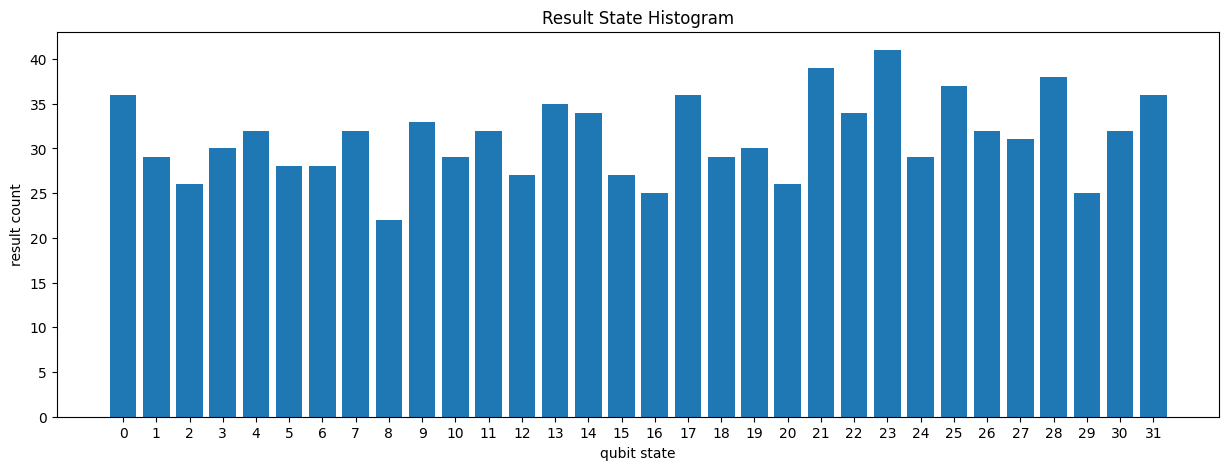

In [4]:
plt.figure(figsize=(15, 5))
cirq.plot_state_histogram(samples, plt.subplot())
plt.show()

# Circuit 2

Swap test is a procedure to check the difference between two quantum states. They


There are three ways on (with minor differences) cirq to construct the same quantum circuit. All of them will be given below

## Way1: Creating Custom Gates

To create gates out of repeating swap test operations

In [5]:
# Define the number of qubits
num_qubits = 6 # 4 actual qubits + 2 ancillary qubits

# Create a circuit
circuit2 = cirq.Circuit()

# Define the qubits
qubits = [cirq.LineQubit(i) for i in range(num_qubits)]

# Apply Hadamard gate to the first qubit
circuit2.append(cirq.H(qubits[0]))

# Rotate the second qubit by pi/3 around X
circuit2.append(cirq.rx(np.pi / 3).on(qubits[1]))

# Apply Hadamard gate to the third and fourth qubit
circuit2.append(cirq.H(qubits[2]))
circuit2.append(cirq.H(qubits[3]))

# Display the circuit
# print(circuit2)

In [6]:
# Define a swap test gate.
class SwapTest(cirq.Gate):
    def __init__(self):
        super(SwapTest, self)

    def _num_qubits_(self):
        return 3

    def _decompose_(self, qubits):
        yield cirq.H(qubits[2])
        yield cirq.CSWAP(qubits[2], qubits[0], qubits[1])
        yield cirq.H(qubits[2])

    def _circuit_diagram_info_(self, args):
        return ["ST-X", "ST-X", "ST-C"]


swap_test = SwapTest()
print(swap_test)

In [7]:
# add the swap-test gate to the circuit

circuit2.append(swap_test(qubits[0], qubits[1], qubits[4]))
circuit2.append(swap_test(qubits[2], qubits[3], qubits[5]), strategy=InsertStrategy.NEW)
print(circuit2)

0: ───H────────────ST-X──────────
                   │
1: ───Rx(0.333π)───ST-X──────────
                   │
2: ───H────────────┼──────ST-X───
                   │      │
3: ───H────────────┼──────ST-X───
                   │      │
4: ────────────────ST-C───┼──────
                          │
5: ───────────────────────ST-C───


Simulate the circuit:
measurements: result=00000

qubits: (cirq.LineQubit(0),)
output vector: (0.707-0.707j)|0⟩

qubits: (cirq.LineQubit(1),)
output vector: |0⟩

qubits: (cirq.LineQubit(2),)
output vector: |0⟩

qubits: (cirq.LineQubit(3),)
output vector: |0⟩

qubits: (cirq.LineQubit(4),)
output vector: |0⟩

phase:
output vector: |⟩


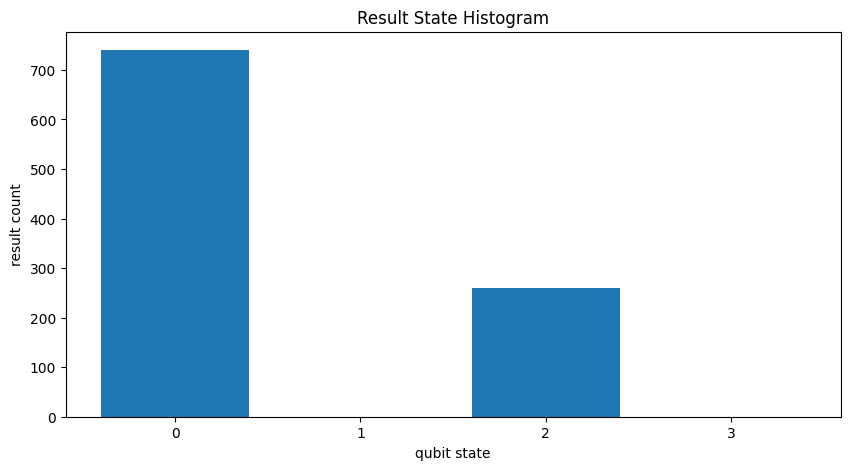

In [8]:
# Initialize Simulator
s2 = cirq.Simulator()

print('Simulate the circuit:')
results2 = s2.simulate(circuit)
print(results2)

# For sampling, we need to add a measurement at the end
circuit2.append(cirq.measure(qubits[4], qubits[5], key='result'))

# Sample the circuit
samples2 = s2.run(circuit2, repetitions=1000)

plt.figure(figsize=(10, 5))
cirq.plot_state_histogram(samples2, plt.subplot())
plt.show()

## Way2: Appending Subcircuits

We can also append subcircuits directly to the circuits by first making the sub-circuit (ie., swap testing) into an operation using ```cirq.CircuitOperation(subcircuit.freeze()) ``` method

And then append it directly to the main circuit and change the targeted qubits by using ```circuit3.append(swap_test_op.with_qubit_mapping(dictionary))```
the ```dictionary``` will consist of ```key : value``` mappings of old qubits to new qubits


In [9]:
# Define the number of qubits
num_qubits = 6

# Create a circuit
circuit3 = cirq.Circuit()

# Define the qubits
qubits3 = [cirq.LineQubit(i) for i in range(num_qubits)]

# Apply Hadamard gate to the first qubit
circuit3.append(cirq.H(qubits3[0]))

# Rotate the second qubit by pi/3 around X
circuit3.append(cirq.rx(np.pi / 3).on(qubits3[1]))

# Apply Hadamard gate to the third and fourth qubit
circuit3.append(cirq.H(qubits3[2]))
circuit3.append(cirq.H(qubits3[3]))

In [10]:
# Define the swap test circuit
swap_test_circuit = cirq.Circuit()
swap_test_qubits = [cirq.LineQubit(i) for i in range(3)]

swap_test_circuit.append(cirq.H(swap_test_qubits[2]))
swap_test_circuit.append(cirq.CSWAP(swap_test_qubits[2], swap_test_qubits[0], swap_test_qubits[1]))
swap_test_circuit.append(cirq.H(swap_test_qubits[2]))

print("swap-test circuit")
print(swap_test_circuit)

# now append the swap test circuits to original circuit
swap_test_op = cirq.CircuitOperation(swap_test_circuit.freeze())
circuit3.append(swap_test_op.with_qubit_mapping({swap_test_qubits[2]:qubits3[4], swap_test_qubits[0]:qubits3[0], swap_test_qubits[1]:qubits3[1]}))
circuit3.append(swap_test_op.with_qubit_mapping({swap_test_qubits[2]:qubits3[5], swap_test_qubits[0]:qubits3[2], swap_test_qubits[1]:qubits3[3]}))

print("\n\ntotal circuit with swap tests included")
print(circuit3)

swap-test circuit
0: ───────×───────
          │
1: ───────×───────
          │
2: ───H───@───H───


total circuit with swap tests included
                   ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
                    [ 0: ───────×─────── ]
                    [           │        ]
0: ───H─────────────[ 1: ───────×─────── ]──────────────────────────────────────────────────────────────────────────────────────────────────
                    [           │        ]
                    [ 2: ───H───@───H─── ](qubit_map={q(2): q(4)})
                    │
1: ───Rx(0.333π)────#2──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                    │
                    │                                             [ 0: ───────×─────── ]
                    │                                             [           │        ]
2: ───H─────────────┼─

Simulate the circuit:
measurements: result=00001

qubits: (cirq.LineQubit(0),)
output vector: (0.707-0.707j)|0⟩

qubits: (cirq.LineQubit(1),)
output vector: |0⟩

qubits: (cirq.LineQubit(2),)
output vector: |0⟩

qubits: (cirq.LineQubit(3),)
output vector: |0⟩

qubits: (cirq.LineQubit(4),)
output vector: |1⟩

phase:
output vector: |⟩


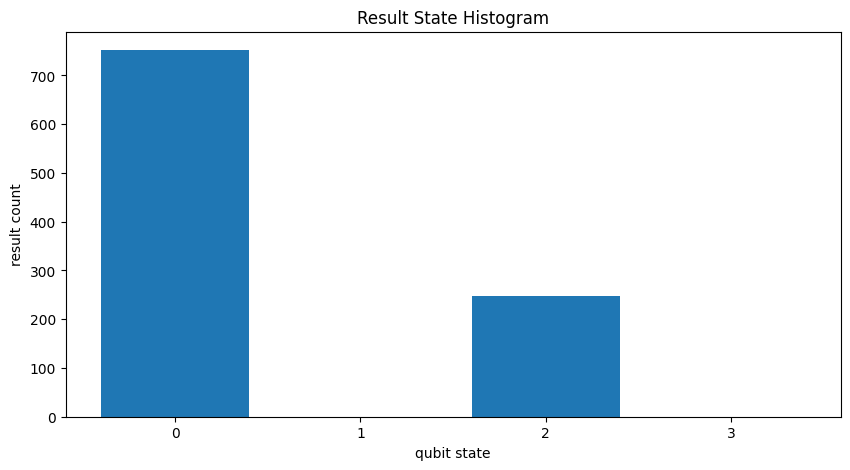

In [11]:
# Initialize Simulator
s3 = cirq.Simulator()

print('Simulate the circuit:')
results3 = s3.simulate(circuit)
print(results3)

# For sampling, we need to add a measurement at the end
circuit3.append(cirq.measure(qubits3[4], qubits3[5], key='result'))

# Sample the circuit
samples3 = s3.run(circuit3, repetitions=1000)

plt.figure(figsize=(10, 5))
cirq.plot_state_histogram(samples3, plt.subplot())
plt.show()

## Way3: Manually constructing the whole circuit

In this method we manually construct the whole circuit from its decomposed gates, hand calculating what gates act on what qubits.

In [12]:
# Define the number of qubits
num_qubits = 6

# Create a circuit
circuit4 = cirq.Circuit()

# Define the qubits
qubits4 = [cirq.LineQubit(i) for i in range(num_qubits)]

# Apply Hadamard gate to the first qubit
circuit4.append(cirq.H(qubits4[0]))

# Rotate the second qubit by pi/3 around X
circuit4.append(cirq.rx(np.pi / 3).on(qubits4[1]))

# Apply Hadamard gate to the third and fourth qubit
circuit4.append(cirq.H(qubits4[2]))
circuit4.append(cirq.H(qubits4[3]))

# swap test on q0, q1 and results on q4
circuit4.append(cirq.H(qubits4[4]), strategy=InsertStrategy.NEW)
circuit4.append(cirq.CSWAP(*[qubits4[k] for k in [4, 0, 1]]))
circuit4.append(cirq.H(qubits4[4]))

circuit4.append(cirq.H(qubits4[5]), strategy=InsertStrategy.NEW)
circuit4.append(cirq.CSWAP(*[qubits4[k] for k in [5, 2, 3]]))
circuit4.append(cirq.H(qubits4[5]))
# NEW insert strategy to seperate the two operations and keep the circuit clean

print(circuit4)

0: ───H────────────────×───────────────────
                       │
1: ───Rx(0.333π)───────×───────────────────
                       │
2: ───H────────────────┼───────────×───────
                       │           │
3: ───H────────────────┼───────────×───────
                       │           │
4: ────────────────H───@───H───────┼───────
                                   │
5: ────────────────────────────H───@───H───


Simulate the circuit:
measurements: result=01110

qubits: (cirq.LineQubit(0),)
output vector: (0.707-0.707j)|0⟩

qubits: (cirq.LineQubit(1),)
output vector: |1⟩

qubits: (cirq.LineQubit(2),)
output vector: |1⟩

qubits: (cirq.LineQubit(3),)
output vector: |1⟩

qubits: (cirq.LineQubit(4),)
output vector: |0⟩

phase:
output vector: |⟩


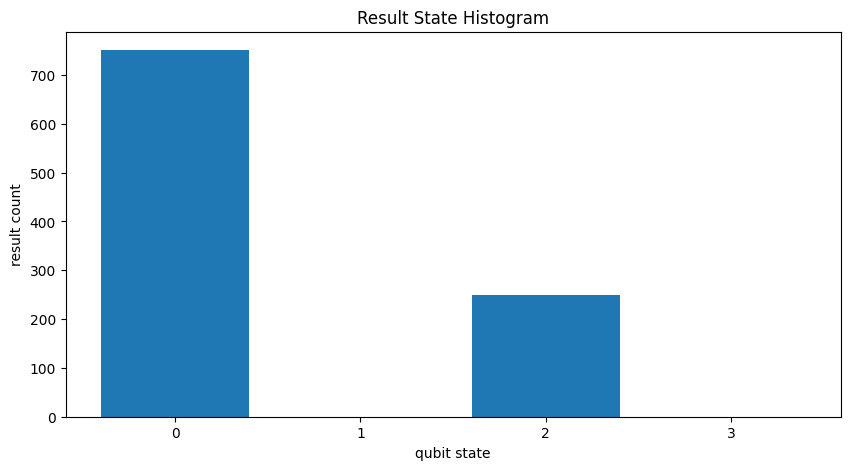

In [13]:
# Initialize Simulator
s4 = cirq.Simulator()

print('Simulate the circuit:')
results4 = s4.simulate(circuit)
print(results4)

# For sampling, we need to add a measurement at the end
circuit4.append(cirq.measure(qubits4[4], qubits4[5], key='result'))

# Sample the circuit
samples4 = s4.run(circuit4, repetitions=1000)

plt.figure(figsize=(10, 5))
cirq.plot_state_histogram(samples4, plt.subplot())
plt.show()

## Results and discussion

- All the three methods gave similar results. Note that results might vary when the three are compared extremely closely because of the probabilistic nature of measurments on the last 2 qubits


- But all the times, we have obtain roughly 75% probability of |00> state and 25% probability of |10> state

- This states that qubit 6 is always |0>, which is an indicator of states |q3> and |q4> are identical states (which is true).

- The 75 % probability of getting |0> in qubit 5 states that |q0> and |q1> are not equal (since probability is not 1), but it also gives us the overlap (inner product) between the 2 states, using the formula,

$$P(|q_6\rangle = |0\rangle) \approx 0.75 = \frac{1}{2} + \frac{1}{2}|\langle q_0 | q_1 \rangle|^2$$

$$ \implies |\langle q_0 | q_1 \rangle|^2 = 0.5 $$


Since we know what the states are, we can verify the results

$$ |q_0\rangle = \frac{1}{\sqrt2} (|0\rangle + |1\rangle) $$


We can get to know q1 without doing the math by simulating the statevector directly

In [14]:
test_qubit = cirq.LineQubit(1)
circ = cirq.Circuit(cirq.rx(np.pi / 3).on(test_qubit))
print(circ)

1: ───Rx(0.333π)───


In [15]:
simulator = cirq.Simulator()
result = simulator.simulate(circ)

print(result)

measurements: (no measurements)

qubits: (cirq.LineQubit(1),)
output vector: 0.866|0⟩ - 0.5j|1⟩

phase:
output vector: |⟩


From the output, we got to know the amplitudes of |0> and |1>. So,

$$ |q_1\rangle = \frac{\sqrt3}{2}|0\rangle - \frac{i}{2}|1\rangle $$

then

$$ |\langle q_0 | q_1 \rangle|^2 = | \frac{\sqrt3}{2} \cdot \frac{1}{\sqrt2} + \frac{1}{\sqrt2} \cdot \frac{i}{2} |^2$$

$$ \implies |\langle q_0 | q_1 \rangle|^2 = |\frac{\sqrt3 - i}{2\sqrt2}|^2 $$

$$ \implies |\langle q_0 | q_1 \rangle|^2 = \frac{3 + 1}{8} = 0.5 $$

Which is what we obtained from the measurements.